
Confusion Matrix:
 [[ 59   4]
 [  5 103]]


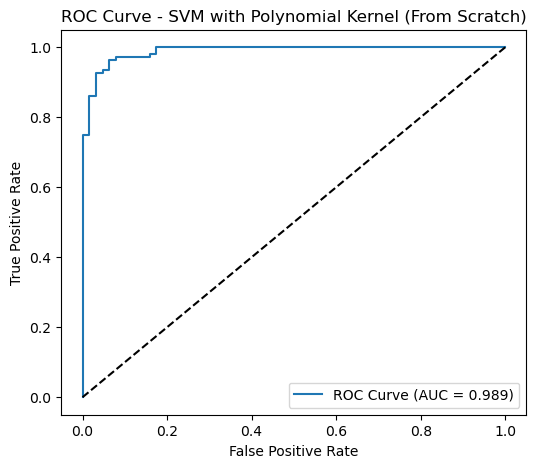

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1) LOAD DATA
# -------------------------------------------------------
df = pd.read_csv("Breast Cancer Wisconsin (Diagnostic)_21.csv")

# Select useful numeric features
features = ['radius_mean', 'texture_mean', 'perimeter_mean', 
            'area_mean', 'smoothness_mean']

X = df[features].values
y = df['diagnosis'].map({'M': -1, 'B': 1}).values   # M = malignant, B = benign

# -------------------------------------------------------
# 2) TRAIN-TEST SPLIT & SCALING
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -------------------------------------------------------
# 3) POLYNOMIAL KERNEL FUNCTION
# -------------------------------------------------------
def poly_kernel(x, z, degree=3):
    return (np.dot(x, z) + 1) ** degree

# -------------------------------------------------------
# 4) SVM DUAL FORM TRAINING (Alpha Optimization)
# -------------------------------------------------------
def train_kernel_svm(X, y, lr=0.01, lambda_param=0.01, epochs=15, degree=3):
    n = X.shape[0]
    alpha = np.zeros(n)

    # Compute full kernel matrix
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = poly_kernel(X[i], X[j], degree)
    
    # Update alpha coefficients
    for _ in range(epochs):
        for i in range(n):
            decision = np.sum(alpha * y * K[:, i])
            if y[i] * decision < 1:
                alpha[i] += lr
            else:
                alpha[i] -= lr * lambda_param
    
    return alpha, K

alpha, K_train = train_kernel_svm(X_train, y_train, degree=3)

# -------------------------------------------------------
# 5) PREDICT FUNCTION
# -------------------------------------------------------
def decision_function(X_train, x, y_train, alpha, degree=3):
    return np.sum(alpha * y_train * np.array([poly_kernel(x, x_i, degree) for x_i in X_train]))

def predict_kernel_svm(X_train, X_test, y_train, alpha, degree=3):
    preds = []
    scores = []
    for x in X_test:
        s = decision_function(X_train, x, y_train, alpha, degree)
        scores.append(s)
        preds.append(1 if s >= 0 else -1)
    return np.array(preds), np.array(scores)

y_pred, scores = predict_kernel_svm(X_train, X_test, y_train, alpha, degree=3)

# -------------------------------------------------------
# 6) CONFUSION MATRIX
# -------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# -------------------------------------------------------
# 7) ROC CURVE
# -------------------------------------------------------
fpr, tpr, _ = roc_curve(np.where(y_test==1, 1, 0), scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM with Polynomial Kernel (From Scratch)")
plt.legend()
plt.show()


In [2]:
# -------------------- PREDICT NEW PATIENTS --------------------

def predict_patient(radius, texture, perimeter, area, smoothness):
    # Prepare input
    x = np.array([[radius, texture, perimeter, area, smoothness]])
    
    # Apply same scaling used in training
    x = scaler.transform(x)
    
    # Compute decision score
    score = np.sum(alpha * y_train * np.array([poly_kernel(x[0], xi, degree=3) for xi in X_train]))
    
    if score >= 0:
        return "BENIGN (Non-cancerous)"
    else:
        return "MALIGNANT (Cancer detected)"


# -------------------- TEST CASES --------------------

print("\n--- SAMPLE TEST CASE PREDICTIONS ---")

# Test Case 1: Likely Benign tumor
print("Patient A:", predict_patient(12.5, 14.2, 78.0, 480.0, 0.095))

# Test Case 2: Likely Malignant tumor
print("Patient B:", predict_patient(18.2, 22.5, 120.3, 1040.0, 0.145))



--- SAMPLE TEST CASE PREDICTIONS ---
Patient A: BENIGN (Non-cancerous)
Patient B: MALIGNANT (Cancer detected)
